# Characterizing Patronage on YouTube - EDA

## 0. Files and brief explanation of those

All data is located in `/dlabdata1/youtube_large/`

In [1]:
DATA_FOLDER = "/dlabdata1/youtube_large/"
LOCAL_DATA_FOLDER = "local_data/"

**YouNiverse dataset:**

- `df_channels_en.tsv.gz`: channel metadata.
- `df_timeseries_en.tsv.gz`: channel-level time-series.
- `yt_metadata_en.jsonl.gz`: raw video metadata.
- `youtube_comments.tsv.gz`: user-comment matrices.
- `youtube_comments.ndjson.zst`: raw comments — this is a HUGE file.

**Graphteon dataset:**
- `creators.csv` list with all creator names.
- `final_processed_file.jsonl.gz` all graphteon time-series.
- `pages.zip` raw html of the pages in graphteon.

#### Libaries imports

In [2]:
import os 
import io
import pandas as pd
import json
import re
import zstandard
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import numpy as np
import seaborn as sns
import gzip
from tqdm import tqdm
import timeit
import ast
import math
import ruptures as rpt

In [3]:
# list all files in DATA_FOLDER
# !ls -lh {DATA_FOLDER}

## 1. Exploratory Data Analysis (EDA)

### 1.1. YouNiverse dataset

#### 1.1.1 Channel metadata
Metadata associated with the 136,470 channels: **channel ID**, **join date**, **country**, **number of subscribers**, **most frequent category**, and the **channel’s position** in socialblade.com’s subscriber ranking. \
The number of subscribers is provided both as obtained from channelcrawler.com (between 2019-09-12 and 2019-09-17) and as crawled from socialblade.com (2019-09-27). Additionally, we also provide a set of **weights** (derived from socialblade.com’s subscriber rankings) that can be used to partially correct sample biases in our dataset.

- `category_cc`: category of the channel (majority based)
- `join_date`: join date of the channel
- `channel`: channel id
- `name_cc`: name of the channel.
- `subscribers_cc`: number of subscribers
- `videos_cc`: number of videos
- `subscriber_rank_sb`: rank in terms of number of subscribers (channel’s position in socialblade.com’s subscriber ranking)
- `weights`: weights cal (Set of weights derived from socialblade.com’s subscriber rankings. Can be used to partially correct sample biases in our dataset. -> correction for representation)

In [4]:
!ls -lh {DATA_FOLDER}df_channels_en.tsv.gz

-rw-r--r-- 1 horta dlab_AppGrpU 5.7M Dec 18  2020 /dlabdata1/youtube_large/df_channels_en.tsv.gz


In [5]:
# channel metadata
df_yt_channels = pd.read_csv(DATA_FOLDER+'df_channels_en.tsv.gz', sep="\t", compression='gzip')
df_yt_channels

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.0870
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.0870
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.0870
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.0870
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.0870
...,...,...,...,...,...,...,...,...
136465,Music,2016-10-06,UCuM-9AajUOwKw6ipOzu2DRQ,GONE.Fludd - Topic,10128,105,1008139.0,53.1435
136466,People & Blogs,2013-10-17,UCtW9jp5TH0YrgYpwiRf9t-Q,saidthestory,10100,352,1008644.0,53.1435
136467,Gaming,2015-05-08,UCTsxFTIUs8vFDzGccDm6i7Q,Omni H,10000,475,1009505.0,53.1435
136468,Music,2011-04-13,UC1HOArgRCMGPjlcmkThERwA,TĀLĀ,10000,15,1025119.0,53.1435


Facts about this data (taken from [YouNiverse github page](https://github.com/epfl-dlab/YouNiverse)) 

- This dataframe has 136,470 rows, where each one corresponds to a different channel.
- We obtained all channels with >10k subscribers and >10 videos from channelcrawler.com in the 27 October 2019.
- Additionally we filtered all channels that were not in english given their video metadata (see `Raw Channels').

##### Summary statistics

In [6]:
print('Number of unique categories:         {:,}'.format(df_yt_channels['category_cc'].nunique()))
print('Number of unique channels:      {:,}'.format(df_yt_channels['channel'].nunique()))
print('Number of unique channel names: {:,}'.format(df_yt_channels['name_cc'].nunique()))

print('\nNote: there are more unique channels than unique names, so some channels might have the same name!')

Number of unique categories:         15
Number of unique channels:      136,470
Number of unique channel names: 135,691

Note: there are more unique channels than unique names, so some channels might have the same name!


##### Distribution of videos and subscribers per channel

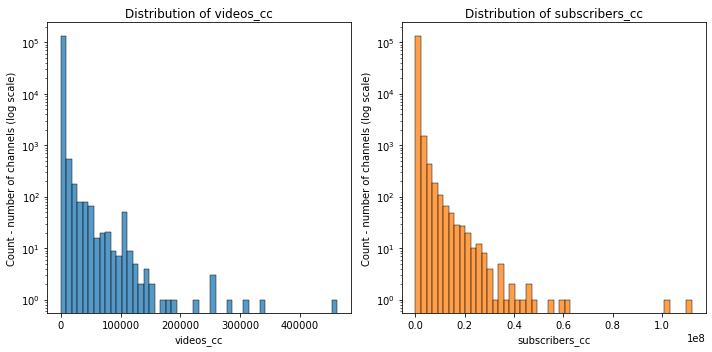

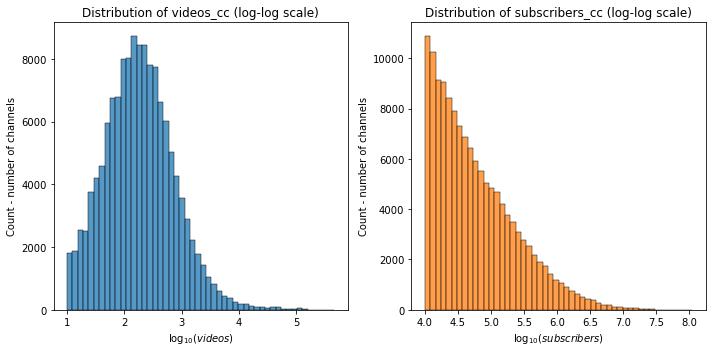

,count,mean,std,min,25%,50%,75%,max
videos_cc,136470.0,699.784231,4.524981e+03,10.0,70.00,175.0,443.0,461923.0
subscribers_cc,136470.0,246602.237884,1.150096e+06,10000.0,18885.75,42400.0,137000.0,112139463.0


In [7]:
selected_cols = ['videos_cc', 'subscribers_cc']

# plot with linear scale for x axis and log scale for y axis
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
    sns.histplot(data=df_yt_channels[col], ax=ax, bins=50, kde=False, color=f'C{i}')
    ax.set(title=f'Distribution of {col}')
    ax.set_ylabel("Count - number of channels (log scale)")
    ax.set(yscale="log")
    # ax.set(xscale="log")
plt.tight_layout()
plt.show()


# plot with log scale for x axis 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

xlabels = [r'$\log_{10}(videos)$', r'$\log_{10}(subscribers)$']

for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
    sns.histplot(data=np.log10(df_yt_channels[col]), ax=ax, bins=50, kde=False, cumulative=False, color=f'C{i}')

    ax.set(title=f'Distribution of {col} (log-log scale)')
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel("Count - number of channels")

    # ax.set(yscale="log")
    # ax.set(xscale="log")
plt.tight_layout()
plt.show()


# plot with linear scale for both axes 
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
#     sns.histplot(data=df_yt_channels[col], ax=ax, bins=50, kde=False, color=f'C{i}')
#     ax.set(title=f'Distribution of {col}')
#     ax.set_ylabel("Count - number of channels")
#     # ax.set(yscale="log")
#     ax.set(xscale="log")
# plt.tight_layout()
# plt.show()

# # plot with log scale for x axis (distplot)
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
#     sns.distplot(np.log10(df_yt_channels[col]), hist_kws=kwargs, kde=False, kde_kws=kwargs, ax=ax, norm_hist=True)

#     ax.set(title=f'Distribution of {col} (log-log scale)')
#     ax.set_ylabel("Count - number of channels")
#     # ax.set(yscale="log")
#     # ax.set(xscale="log")
# plt.tight_layout()
# plt.show()


# descriptive statistics table
df_yt_channels[selected_cols].describe().T

**Discussion:** \
From the above graphs and table, we can see that _videos_ and _subscribers_ distributions among YouTube channels follow a **power law**, meaning that most channels have a only a few videos and a few subscribers, but a few of them have a lot of videos and a lot of subscribers.

More specifically:
- 50% of the YouTube channels have less than 175 videos
- 50% of the YouTube channels have less than 42,400 subscribers

_Note: only channels with at least 10 videos and 10,000 subscribers were considered for this study._

##### Group by categories

In [8]:
data_per_cat_chan = df_yt_channels.groupby(['category_cc', 'channel'])[['videos_cc', 'subscribers_cc']].agg(['max'])

# set the columns to the top level of the multi-index
data_per_cat_chan.columns = data_per_cat_chan.columns.get_level_values(0)
data_per_cat_chan

videos_cc  subscribers_cc
category_cc      channel                                            
Autos & Vehicles UC--aOG_a2afAna8t3xvRkuw         51           27800
                 UC-1CvlOVGAUzvffUyLOQ0hA        137           19500
                 UC-1PkmLrFt6apyXAnB0LbNw        304          151000
                 UC-1W6GKASWrqZfK45zFLapg        203           27000
                 UC-31-rclcsuDPqfwh-rENuw         49           24300
...                                              ...             ...
Travel & Events  UCztXZVQiVSqoDTC9USNPeqQ        858           20200
                 UCzuKzSNb8hGV9DsqIBUb79w        224          152000
                 UCzvCf_q10UZkUJE0lOav0ag        141          155000
                 UCzwwBSRb4pYlJ4DIVh_Am2A         16           10101
                 UCzxWFIJccSKOfRmLiMOs-Fw        641           27000

[136342 rows x 2 columns]

In [9]:
data_per_cat_chan.reset_index(inplace=True)
data_per_cat_chan

,category_cc,channel,videos_cc,subscribers_cc
0,Autos & Vehicles,UC--aOG_a2afAna8t3xvRkuw,51,27800
1,Autos & Vehicles,UC-1CvlOVGAUzvffUyLOQ0hA,137,19500
2,Autos & Vehicles,UC-1PkmLrFt6apyXAnB0LbNw,304,151000
3,Autos & Vehicles,UC-1W6GKASWrqZfK45zFLapg,203,27000
4,Autos & Vehicles,UC-31-rclcsuDPqfwh-rENuw,49,24300
...,...,...,...,...
136337,Travel & Events,UCztXZVQiVSqoDTC9USNPeqQ,858,20200
136338,Travel & Events,UCzuKzSNb8hGV9DsqIBUb79w,224,152000
136339,Travel & Events,UCzvCf_q10UZkUJE0lOav0ag,141,155000
136340,Travel & Events,UCzwwBSRb4pYlJ4DIVh_Am2A,16,10101


##### Number of channels per category

In [10]:
chan_per_cat = data_per_cat_chan.groupby('category_cc')[['channel']].count().sort_values('channel', ascending=False)

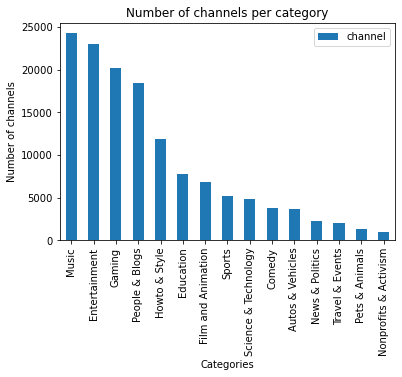

category_cc
Music                    24285
Entertainment            22951
Gaming                   20143
People & Blogs           18413
Howto & Style            11875
Education                 7803
Film and Animation        6875
Sports                    5148
Science & Technology      4864
Comedy                    3767
Autos & Vehicles          3705
News & Politics           2263
Travel & Events           1989
Pets & Animals            1292
Nonprofits & Activism      969
Name: channel, dtype: int64

In [11]:
chan_per_cat.plot(kind='bar')
plt.title("Number of channels per category")
plt.xlabel("Categories")
plt.ylabel("Number of channels")
plt.show()
chan_per_cat['channel']

In [12]:
# data_per_cat = data_per_cat_chan.groupby('category')['videos_cc','subscribers_cc'].agg(['min', 'max', 'count', 'sum'])
data_per_cat = data_per_cat_chan.groupby('category_cc')[['videos_cc','subscribers_cc']].agg(['sum'])
data_per_cat.columns = data_per_cat.columns.get_level_values(0)
data_per_cat = data_per_cat.add_suffix('_sum')
data_per_cat

,videos_cc_sum,subscribers_cc_sum
category_cc,,
Autos & Vehicles,2527509,411841780
Comedy,1081541,1627752653
Education,4314309,2092785162
Entertainment,14821851,8064599847
Film and Animation,2237992,1569170575
Gaming,15126639,4069337970
Howto & Style,4660134,2767146995
Music,16179141,7094489634
News & Politics,17751894,666846102


##### Number of videos per category

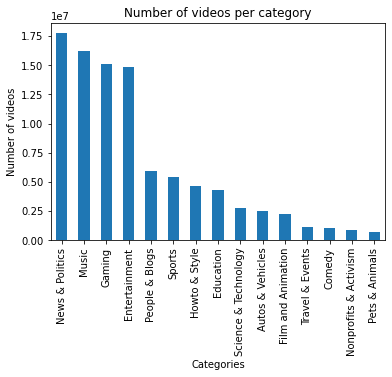

category_cc
News & Politics          17751894
Music                    16179141
Gaming                   15126639
Entertainment            14821851
People & Blogs            5945267
Sports                    5424965
Howto & Style             4660134
Education                 4314309
Science & Technology      2733493
Autos & Vehicles          2527509
Film and Animation        2237992
Travel & Events           1103153
Comedy                    1081541
Nonprofits & Activism      874782
Pets & Animals             667578
Name: videos_cc_sum, dtype: int64

In [13]:
data_per_cat['videos_cc_sum'].sort_values(ascending=False).plot(kind='bar')
plt.title("Number of videos per category")
plt.xlabel("Categories")
plt.ylabel("Number of videos")
plt.show()

data_per_cat['videos_cc_sum'].sort_values(ascending=False)

##### Number of subscribers per category

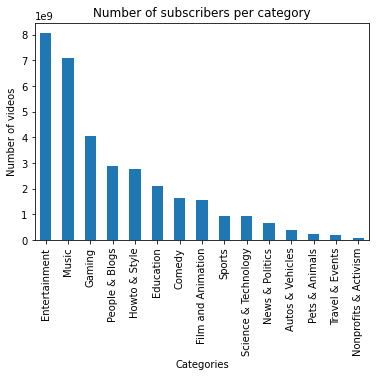

category_cc
Entertainment            8064599847
Music                    7094489634
Gaming                   4069337970
People & Blogs           2870984478
Howto & Style            2767146995
Education                2092785162
Comedy                   1627752653
Film and Animation       1569170575
Sports                    949684213
Science & Technology      938007818
News & Politics           666846102
Autos & Vehicles          411841780
Pets & Animals            233952325
Travel & Events           192520018
Nonprofits & Activism      91713625
Name: subscribers_cc_sum, dtype: int64

In [14]:
data_per_cat['subscribers_cc_sum'].sort_values(ascending=False).plot(kind='bar')
plt.title("Number of subscribers per category")
plt.xlabel("Categories")
plt.ylabel("Number of videos")
plt.show()

data_per_cat['subscribers_cc_sum'].sort_values(ascending=False)

#### 1.1.2 YouTube Channels time-series data
Weekly number of viewers and subscribers. We have a data point for each channel and each week.

Time series of channel activity at **weekly granularity**. The span of time series varies by channel depending on when socialblade.com started tracking the channel. On average, it contains **2.8 years of data per channel** for **133k channels** (notice that this means there are roughly 4k channels for which there is no time-series data). \
Each data point includes the **number of views** (`views`) and **subscribers** (`subs`) obtained in the given week, as well as the **number of videos** (`videos`) posted by the **channel** (`channel`). The number of videos is calculated using the video upload dates in our video metadata, such that videos that were unavailable at crawl time are not accounted for. 

---

Time series related to each channel.\
These come from a mix of YouTube data and time series crawled from [socialblade.com](https://socialblade.com/):
- From the former (YouTube data): derived weekly time series indicating **how many videos each channel had posted per week**. 
- From the latter (socialblade.com): crawled weekly statistics on the **number of viewers** `views` and **subscribers** `subs` per channel `channel`. This data was available for around 153k channels.

    - `channel`: unique channel ID, which is the numbers and letters at the end of the URL.
    - `category`: category of the channel as assigned by [socialblade.com](https://socialblade.com/) according to the last 10 videos at time of crawl (categories organize channels and videos on YouTube and help creators, advertisers, and channel managers identify with content and audiences they wish to associate with).
    - `datetime`: First day of the week related to the data point
    - `views`: Total number of views the channel had this week.
    - `delta_views`: Delta views obtained this week (difference of nb of views between current and former week). (Interpolation)
    - `subs`: Total number of subscribers the channel had this week.
    - `delta_subs`: Delta subscribers obtained this week (difference of nb of subscribers between current and former week)
    - `videos`: Number of videos posted by the channel up to date
    - `delta_videos`:  Delta videos obtained this week (difference of number of videos posted by the channel between current and former week).
    - `activity`: Number of videos published in the last 15 days.
    
    
Note: Can view the channel by appending the channel id to the url, e.g.  https://www.youtube.com/channel/UCBJuEqXfXTdcPSbGO9qqn1g


In [15]:
!ls -lh /dlabdata1/youtube_large/df_timeseries_en.tsv.gz

-rw-r--r-- 1 horta dlab_AppGrpU 545M Dec 16  2020 /dlabdata1/youtube_large/df_timeseries_en.tsv.gz


In [16]:
# load channel-level time-series. (takes btw 50 secs and 2 mins)
df_yt_timeseries = pd.read_csv(DATA_FOLDER+'df_timeseries_en.tsv.gz', sep="\t", compression='gzip', parse_dates=['datetime'])
df_yt_timeseries

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,2.024946e+05,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,3.940857e+05,191591.111111,1046.000000,395.777778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,8.353938e+05,441308.083333,1501.500000,455.500000,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24,1.104577e+06,269183.250000,1750.000000,248.500000,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31,1.284406e+06,179828.600000,2008.300000,258.300000,6,0,0
...,...,...,...,...,...,...,...,...,...,...
18872494,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-02,6.012938e+06,232418.277778,61268.611111,1305.611111,278,2,10
18872495,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-09,6.244579e+06,231640.888889,62631.666667,1363.055556,287,9,13
18872496,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-16,6.480902e+06,236322.933333,64010.000000,1378.333333,294,7,16
18872497,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-23,6.745317e+06,264415.200000,65480.000000,1470.000000,301,7,15


##### Summary statistics

In [17]:
df_yt_timeseries.describe().T

,count,mean,std,min,25%,50%,75%,max
views,18872499.0,4.515185e+07,3.633229e+08,1.0,1.330733e+06,4.665598e+06,1.628815e+07,8.411483e+10
delta_views,18872499.0,3.818116e+05,4.062719e+06,0.0,9.197109e+03,3.356228e+04,1.309393e+05,6.659719e+09
subs,18872499.0,1.527369e+05,8.073176e+05,1.0,9.033000e+03,2.090667e+04,7.057127e+04,1.125714e+08
delta_subs,18872499.0,1.312787e+03,1.864629e+04,0.0,3.375000e+01,1.247250e+02,5.147500e+02,2.061360e+07
videos,18872499.0,4.140162e+02,1.439843e+03,0.0,4.100000e+01,1.220000e+02,3.340000e+02,1.418270e+05
delta_videos,18872499.0,2.210536e+00,1.469852e+01,0.0,0.000000e+00,0.000000e+00,2.000000e+00,3.158000e+04
activity,18872499.0,4.916308e+00,2.998487e+01,0.0,0.000000e+00,1.000000e+00,4.000000e+00,3.159700e+04


In [18]:
yt_ts_uniq_chan_cnt = df_yt_timeseries['channel'].nunique()

print('Timeseries data was gathered between {} and {}'.format(df_yt_timeseries['datetime'].min().strftime('%B %d, %Y'),
                                                         df_yt_timeseries['datetime'].max().strftime('%B %d, %Y')))
print('Total number of datapoints accross all channels: {:>12,}'.format(len(df_yt_timeseries)))
data_points_dist = df_yt_timeseries['channel'].value_counts()
print('Average number of datapoints per channel:       {:>12.0f} weeks (≈{:,.1f} years)'.format(data_points_dist.mean(), data_points_dist.mean()/52))
print('Number of unique categories:                     {:>12,}'.format(df_yt_timeseries['category'].nunique()))
print('Number of unique channels:                       {:>12,}'.format(yt_ts_uniq_chan_cnt))

Timeseries data was gathered between January 05, 2015 and September 30, 2019
Total number of datapoints accross all channels:   18,872,499
Average number of datapoints per channel:                141 weeks (≈2.7 years)
Number of unique categories:                               15
Number of unique channels:                            133,516


##### Datetime points per channel

Not all channels timeseries start and end at the same time, therefore we have a different amount of datapoints for each channel

In [19]:
datetime_data = df_yt_timeseries.groupby('channel')['datetime'].agg(['min', 'max'])
datetime_data.head()

,min,max
channel,,
UC--24Q3_ZQeFmgJE-Um5QZQ,2016-08-01,2019-09-23 00:00:00
UC--2EbuIuBOGgGqPiJxi3rg,2016-06-27,2019-09-30 00:00:00
UC--3c8RqSfAqYBdDjIG3UNA,2019-02-25,2019-09-30 01:00:00
UC--3ozenTzry39-xMqAPQlw,2016-10-03,2019-09-30 00:00:00
UC--6E6EpybocdaNlPhvK_9A,2016-08-08,2019-09-30 00:00:00


In [20]:
# datetime_data.describe().T

##### Datetime points per year

In [21]:
yt_ts_year_cnt = df_yt_timeseries.groupby(df_yt_timeseries.datetime.dt.year).size()

Timeseries data was gathered between January 05, 2015 and September 30, 2019


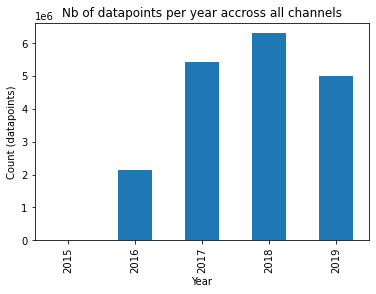

datetime
2015       2164
2016    2137720
2017    5434045
2018    6306258
2019    4992312
dtype: int64

In [22]:
print('Timeseries data was gathered between {} and {}'.format(df_yt_timeseries['datetime'].min().strftime('%B %d, %Y'),
                                                         df_yt_timeseries['datetime'].max().strftime('%B %d, %Y')))
yt_ts_year_cnt.plot(kind='bar')
plt.title("Nb of datapoints per year accross all channels")
plt.xlabel("Year")
plt.ylabel("Count (datapoints)")
plt.show()

yt_ts_year_cnt

##### Datetime points per month

In [23]:
yt_ts_month_cnt = df_yt_timeseries.groupby([df_yt_timeseries.datetime.dt.year, df_yt_timeseries.datetime.dt.month]).size()
yt_ts_month_cnt.head()

datetime  datetime
2015      1           22
          2           32
          3           58
          4           69
          5           77
dtype: int64

In [24]:
# using pandas.Grouper
# yt_ts_month_cnt_grouper = df_yt_timeseries.groupby(pd.Grouper(key='datetime', freq='M')).count().channel
# yt_ts_month_cnt_grouper.head()

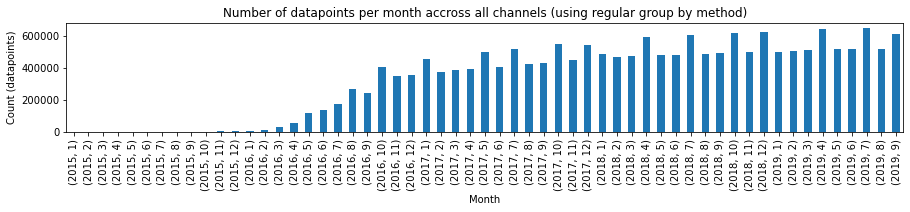

In [25]:
# plot number of datapoints per month
plt.figure(figsize=(15,2))
yt_ts_month_cnt.plot(kind='bar')
plt.title("Number of datapoints per month accross all channels (using regular group by method)")
plt.xlabel("Month")
plt.ylabel("Count (datapoints)")
plt.show()

# plot number of datapoints per month using grouper
# plt.figure(figsize=(15,2))
# yt_ts_month_cnt_grouper.plot(kind='bar')
# plt.title("Number of datapoints per month accross all channels (using grouper)")
# plt.xlabel("Month")
# plt.ylabel("Count (datapoints)")
# plt.show()

In [26]:
# only consider unique values per channel
yt_ts_month_unique_cnt = df_yt_timeseries.groupby(pd.Grouper(key='datetime', freq='M')).agg({"channel": pd.Series.nunique})
yt_ts_month_unique_cnt.head()

,channel
datetime,
2015-01-31,7
2015-02-28,10
2015-03-31,13
2015-04-30,19
2015-05-31,20


In [27]:
(df_yt_timeseries.groupby(['datetime', 'channel']).count() > 1).sum()

category        0
views           0
delta_views     0
subs            0
delta_subs      0
videos          0
delta_videos    0
activity        0
dtype: int64

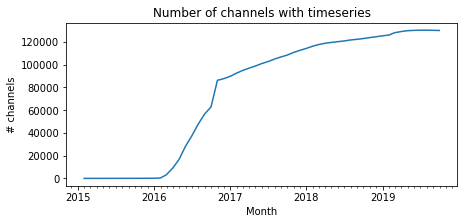

In [28]:
# Number of channels with timeseries (only consider unique values per channel) --> see https://stackoverflow.com/questions/38309729/count-unique-values-per-groups-with-pandas

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month

fig, ax = plt.subplots(1, figsize=(7,3), sharey=True, sharex=True,
                       gridspec_kw={"wspace": 0.05})

ax.plot(yt_ts_month_unique_cnt)

ax.set(title='Number of channels with timeseries')
ax.set_xlabel("Month")
ax.set_ylabel("# channels")
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)

##### Datetime points accross channels

Total number of datapoints accross all channels:   18,872,499
Average number of datapoints per channel:                 141 weeks (≈2.7 years)


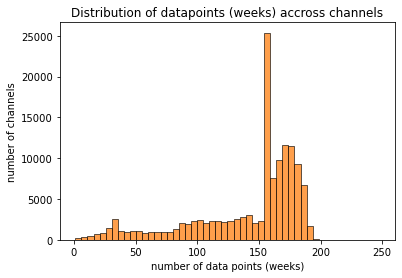

In [29]:
# Distribution of datapoints accross channels

print('Total number of datapoints accross all channels: {:>12,}'.format(len(df_yt_timeseries)))
data_points_dist = df_yt_timeseries['channel'].value_counts()
print('Average number of datapoints per channel:        {:>12,.0f} weeks (≈{:,.1f} years)'.format(data_points_dist.mean(), data_points_dist.mean()/52))

ax = sns.histplot(data=data_points_dist, bins=50, kde=False, color=f'C{1}')

ax.set(title=f'Distribution of datapoints (weeks) accross channels')
ax.set_xlabel('number of data points (weeks)')
ax.set_ylabel('number of channels')

# ax.set(yscale="log")
# plt.tight_layout()
plt.show()

In [30]:
# Aggregates per channel
sel_cols = ['datetime', 'views', 'delta_views', 'subs', 'delta_subs', 'videos', 'delta_videos', 'activity']
data_per_channel = df_yt_timeseries.groupby('channel')[sel_cols].agg(['min', 'max', 'count', 'mean'])
data_per_channel.head()

datetime                            \
                                min                 max count   
channel                                                         
UC--24Q3_ZQeFmgJE-Um5QZQ 2016-08-01 2019-09-23 00:00:00   165   
UC--2EbuIuBOGgGqPiJxi3rg 2016-06-27 2019-09-30 00:00:00   171   
UC--3c8RqSfAqYBdDjIG3UNA 2019-02-25 2019-09-30 01:00:00    32   
UC--3ozenTzry39-xMqAPQlw 2016-10-03 2019-09-30 00:00:00   157   
UC--6E6EpybocdaNlPhvK_9A 2016-08-08 2019-09-30 00:00:00   165   

                                                               views  \
                                                  mean           min   
channel                                                                
UC--24Q3_ZQeFmgJE-Um5QZQ 2018-02-25 23:36:43.636363520  6.252450e+04   
UC--2EbuIuBOGgGqPiJxi3rg 2018-02-11 23:37:32.631578880  2.984862e+06   
UC--3c8RqSfAqYBdDjIG3UNA 2019-06-13 12:50:37.500000000  3.703988e+07   
UC--3ozenTzry39-xMqAPQlw 2018-04-01 23:35:32.484076544  7.669280e+06   
UC--6E6EpybocdaNlPhvK_9A 2018-03-04 23:36:43.636363520  1.900056e+06   

                                                           delta_views  \
                                   max count          mean         min   
channel                                                                  
UC--24Q3_ZQeFmgJE-Um5QZQ  4.356804e+06   165  1.365816e+06         0.0   
UC--2EbuIuBOGgGqPiJxi3rg  7.951972e+06   171  5.559505e+06         0.0   
UC--3c8RqSfAqYBdDjIG3UNA  5.798712e+07    32  4.707118e+07         0.0   
UC--3ozenTzry39-xMqAPQlw  1.455123e+07   157  1.223360e+07         0.0   
UC--6E6EpybocdaNlPhvK_9A  9.166274e+06   165  5.950502e+06         0.0   

                                        ... videos             delta_videos  \
                                   max  ...  count        mean          min   
channel                                 ...                                   
UC--24Q3_ZQeFmgJE-Um5QZQ  7.568855e+05  ...    165  108.236364            0   
UC--2EbuIuBOGgGqPiJxi3rg  6.411512e+04  ...    171   56.269006            0   
UC--3c8RqSfAqYBdDjIG3UNA  1.952233e+06  ...     32  302.968750            0   
UC--3ozenTzry39-xMqAPQlw  1.761543e+05  ...    157   38.159236            0   
UC--6E6EpybocdaNlPhvK_9A  1.181485e+05  ...    165   26.569697            0   

                                             activity                      
                         max count      mean      min max count      mean  
channel                                                                    
UC--24Q3_ZQeFmgJE-Um5QZQ   2   165  0.963636        1   3   165  1.957576  
UC--2EbuIuBOGgGqPiJxi3rg   1   171  0.070175        0   2   171  0.157895  
UC--3c8RqSfAqYBdDjIG3UNA   5    32  1.937500        0   8    32  3.875000  
UC--3ozenTzry39-xMqAPQlw   2   157  0.101911        0   3   157  0.235669  
UC--6E6EpybocdaNlPhvK_9A   1   165  0.060606        0   2   165  0.133333  

[5 rows x 32 columns]

#####  Views per channel

In [31]:
data_per_channel['views'].head()

,min,max,count,mean
channel,,,,
UC--24Q3_ZQeFmgJE-Um5QZQ,6.252450e+04,4.356804e+06,165,1.365816e+06
UC--2EbuIuBOGgGqPiJxi3rg,2.984862e+06,7.951972e+06,171,5.559505e+06
UC--3c8RqSfAqYBdDjIG3UNA,3.703988e+07,5.798712e+07,32,4.707118e+07
UC--3ozenTzry39-xMqAPQlw,7.669280e+06,1.455123e+07,157,1.223360e+07
UC--6E6EpybocdaNlPhvK_9A,1.900056e+06,9.166274e+06,165,5.950502e+06


/tmp/ipykernel_1603353/1726594485.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xlabels1)
/tmp/ipykernel_1603353/1726594485.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(xlabels2)


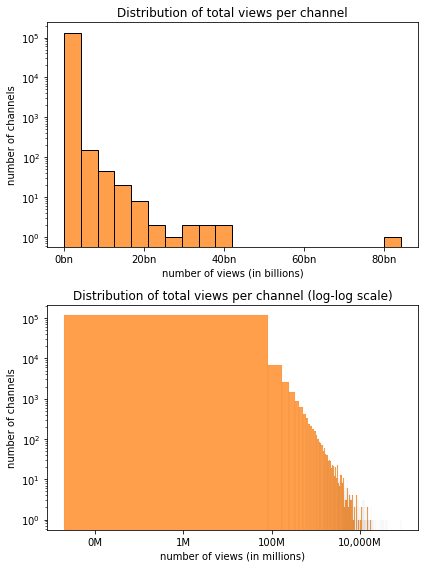

,count,mean,std,min,25%,50%,75%,max
max,133516.0,7.098767e+07,5.420374e+08,1981.017857,3.534713e+06,9.350474e+06,2.983789e+07,8.411483e+10


In [32]:
# Distribution of total views per channel
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,8))

sns.histplot(data=data_per_channel['views']['max'], ax=axs[0], bins=20, kde=False, color=f'C{1}')
axs[0].set(title=f'Distribution of total views per channel')
axs[0].set_xlabel('number of views (in billions)')
axs[0].set_ylabel('number of channels')
axs[0].set(yscale="log")
xlabels1 = ['{:,.0f}'.format(x) + 'bn' for x in axs[0].get_xticks()/1_000_000_000]
axs[0].set_xticklabels(xlabels1)

# Distribution of total views per channel (log scale)
sns.histplot(data=data_per_channel['views']['max'], ax=axs[1], bins=1000, kde=False, color=f'C{1}')
axs[1].set(title=f'Distribution of total views per channel (log-log scale)')
axs[1].set_xlabel('number of views (in millions)')
axs[1].set_ylabel('number of channels')
axs[1].set(yscale="log")
axs[1].set(xscale="log")
xlabels2 = ['{:,.0f}'.format(x) + 'M' for x in axs[1].get_xticks()/1_000_000]
axs[1].set_xticklabels(xlabels2)

plt.tight_layout()
plt.show()

data_per_channel['views'][['max']].describe().T

In [33]:
print("Top 10 channels with the most total views (in billions):")

for index, value in data_per_channel['views']['max'].sort_values(ascending=False)[:10].items():
    print('https://www.youtube.com/channel/{} : {:,.1f} bn views'.format(index, value/1_000_000_000))

Top 10 channels with the most total views (in billions):
https://www.youtube.com/channel/UCq-Fj5jknLsUf-MWSy4_brA : 84.1 bn views
https://www.youtube.com/channel/UCpEhnqL0y41EpW2TvWAHD7Q : 40.8 bn views
https://www.youtube.com/channel/UCbCmjCuTUZos6Inko4u57UQ : 39.7 bn views
https://www.youtube.com/channel/UCJ5v_MCY6GNUBTO8-D3XoAg : 35.9 bn views
https://www.youtube.com/channel/UCppHT7SZKKvar4Oc9J4oljQ : 34.1 bn views
https://www.youtube.com/channel/UChGJGhZ9SOOHvBB0Y4DOO_w : 32.4 bn views
https://www.youtube.com/channel/UCstEtN0pgOmCf02EdXsGChw : 30.1 bn views
https://www.youtube.com/channel/UC3gNmTGu-TTbFPpfSs5kNkg : 27.0 bn views
https://www.youtube.com/channel/UC-lHJZR3Gqxm24_Vd_AJ5Yw : 23.6 bn views
https://www.youtube.com/channel/UC6-F5tO8uklgE9Zy8IvbdFw : 21.8 bn views


##### Videos per channel

In [34]:
data_per_channel['videos'].head()

,min,max,count,mean
channel,,,,
UC--24Q3_ZQeFmgJE-Um5QZQ,29,188,165,108.236364
UC--2EbuIuBOGgGqPiJxi3rg,48,60,171,56.269006
UC--3c8RqSfAqYBdDjIG3UNA,271,333,32,302.968750
UC--3ozenTzry39-xMqAPQlw,27,43,157,38.159236
UC--6E6EpybocdaNlPhvK_9A,21,31,165,26.569697


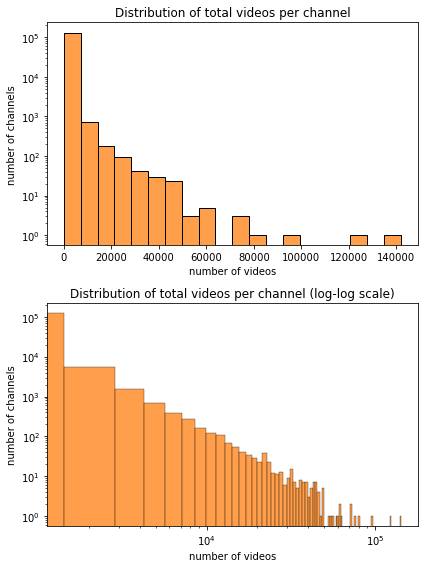

,count,mean,std,min,25%,50%,75%,max
max,133516.0,533.16938,1865.192782,0.0,65.0,169.0,429.0,141827.0


In [35]:
# Distribution of total videos per channel
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
sns.histplot(data=data_per_channel['videos']['max'], ax=axs[0], bins=20, kde=False, color=f'C{1}')

axs[0].set(title=f'Distribution of total videos per channel')
axs[0].set_xlabel('number of videos')
axs[0].set_ylabel('number of channels')
axs[0].set(yscale="log")

# # Distribution of total views per channel (log scale)
sns.histplot(data=data_per_channel['videos']['max'], ax=axs[1], bins=100, kde=False, color=f'C{1}')

axs[1].set(title=f'Distribution of total videos per channel (log-log scale)')
axs[1].set_xlabel('number of videos')
axs[1].set_ylabel('number of channels')
axs[1].set(yscale="log")
axs[1].set(xscale="log")

plt.tight_layout()
plt.show()

data_per_channel['videos'][['max']].describe().T

In [36]:
print("Top 10 channels with the most total videos:")

for index, value in data_per_channel['videos']['max'].sort_values(ascending=False)[:10].items():
    print('https://www.youtube.com/channel/{} : {:,.0f} videos'.format(index, value))

Top 10 channels with the most total videos:
https://www.youtube.com/channel/UCsT0YIqwnpJCM-mx7-gSA4Q : 141,827 videos
https://www.youtube.com/channel/UCstEtN0pgOmCf02EdXsGChw : 122,045 videos
https://www.youtube.com/channel/UCKwucPzHZ7zCUIf7If-Wo1g : 95,505 videos
https://www.youtube.com/channel/UCRNmk0RhyeoHOgcB5xxgqBw : 80,051 videos
https://www.youtube.com/channel/UCeoyATtDjeDXGQzH2ANaYzQ : 75,941 videos
https://www.youtube.com/channel/UC8p1vwvWtl6T73JiExfWs1g : 71,532 videos
https://www.youtube.com/channel/UCt3SE-Mvs3WwP7UW-PiFdqQ : 70,957 videos
https://www.youtube.com/channel/UChkYqBSmrYsPjOTK2N4pdWg : 63,221 videos
https://www.youtube.com/channel/UC8yH-uI81UUtEMDsowQyx1g : 61,839 videos
https://www.youtube.com/channel/UCcv7pspGHmM7AOywuLM1ufA : 61,236 videos


##### Subscribers per channel

In [37]:
data_per_channel['subs'].head()

,min,max,count,mean
channel,,,,
UC--24Q3_ZQeFmgJE-Um5QZQ,1466.00,17316.714286,165,7349.252162
UC--2EbuIuBOGgGqPiJxi3rg,3829.75,14000.000000,171,8619.445394
UC--3c8RqSfAqYBdDjIG3UNA,225.00,75220.238095,32,38978.817612
UC--3ozenTzry39-xMqAPQlw,60882.75,108280.125000,157,91834.593370
UC--6E6EpybocdaNlPhvK_9A,23293.00,94185.714286,165,60647.258076


/tmp/ipykernel_1603353/1970140578.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xlabels0)


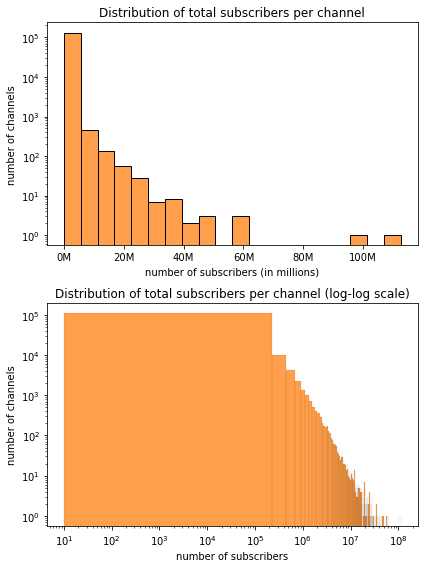

,count,mean,std,min,25%,50%,75%,max
max,133516.0,533.16938,1865.192782,0.0,65.0,169.0,429.0,141827.0


In [38]:
# Distribution of total subscribers per channel
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
sns.histplot(data=data_per_channel['subs']['max'], ax=axs[0], bins=20, kde=False, color=f'C{1}')

axs[0].set(title=f'Distribution of total subscribers per channel')
axs[0].set_xlabel('number of subscribers (in millions)')
axs[0].set_ylabel('number of channels')
axs[0].set(yscale="log")
xlabels0 = ['{:,.0f}'.format(x) + 'M' for x in axs[0].get_xticks()/1_000_000]
axs[0].set_xticklabels(xlabels0)

# # Distribution of total views per channel (log scale)
sns.histplot(data=data_per_channel['subs']['max'], ax=axs[1], bins=500, kde=False, color=f'C{1}')

axs[1].set(title=f'Distribution of total subscribers per channel (log-log scale)')
axs[1].set_xlabel('number of subscribers')
axs[1].set_ylabel('number of channels')
axs[1].set(yscale="log")
axs[1].set(xscale="log")

plt.tight_layout()
plt.show()

data_per_channel['videos'][['max']].describe().T

In [39]:
data_per_channel['subs']['max'].sort_values(ascending=False)[:10]

channel
UCq-Fj5jknLsUf-MWSy4_brA    1.125714e+08
UC-lHJZR3Gqxm24_Vd_AJ5Yw    1.010909e+08
UCbCmjCuTUZos6Inko4u57UQ    6.128571e+07
UC295-Dw_tDNtZXFeAPAW6Aw    6.080119e+07
UCpEhnqL0y41EpW2TvWAHD7Q    5.672857e+07
UCJ5v_MCY6GNUBTO8-D3XoAg    4.887143e+07
UCIwFjwMjI0y7PDBVEO9-bkQ    4.668571e+07
UCRijo3ddMTht_IHyNSNXpNQ    4.604286e+07
UCFFbwnve3yF62-tVXkTyHqg    4.380000e+07
UC0C-w0YjGpqDXGB8IHb662A    4.210000e+07
Name: max, dtype: float64

In [40]:
print("Top 10 channels with the most total subscribers:")

for index, value in data_per_channel['subs']['max'].sort_values(ascending=False)[:10].items():
    print('https://www.youtube.com/channel/{} : {:,.1f}M subscribers'.format(index, value/1_000_000))

Top 10 channels with the most total subscribers:
https://www.youtube.com/channel/UCq-Fj5jknLsUf-MWSy4_brA : 112.6M subscribers
https://www.youtube.com/channel/UC-lHJZR3Gqxm24_Vd_AJ5Yw : 101.1M subscribers
https://www.youtube.com/channel/UCbCmjCuTUZos6Inko4u57UQ : 61.3M subscribers
https://www.youtube.com/channel/UC295-Dw_tDNtZXFeAPAW6Aw : 60.8M subscribers
https://www.youtube.com/channel/UCpEhnqL0y41EpW2TvWAHD7Q : 56.7M subscribers
https://www.youtube.com/channel/UCJ5v_MCY6GNUBTO8-D3XoAg : 48.9M subscribers
https://www.youtube.com/channel/UCIwFjwMjI0y7PDBVEO9-bkQ : 46.7M subscribers
https://www.youtube.com/channel/UCRijo3ddMTht_IHyNSNXpNQ : 46.0M subscribers
https://www.youtube.com/channel/UCFFbwnve3yF62-tVXkTyHqg : 43.8M subscribers
https://www.youtube.com/channel/UC0C-w0YjGpqDXGB8IHb662A : 42.1M subscribers


In [41]:
# set the columns to the top level of the multi-index
# data_per_channel.columns = data_per_channel.columns.get_level_values(0)
# data_per_channel

#### 1.1.3 Raw video metadata
The file `df_videos_raw.jsonl.gz` contains metadata data related to ~73M videos from ~137k channels. Below we show the data recorded for each of the video

In [42]:
!ls -lh {DATA_FOLDER}yt_metadata_en.jsonl.gz

-rw-r--r-- 1 horta dlab_AppGrpU 13G Dec 18  2020 /dlabdata1/youtube_large/yt_metadata_en.jsonl.gz


In [43]:
# ! zcat {DATA_FOLDER}yt_metadata_en.jsonl.gz | head

In [44]:
df_yt_metadata = pd.read_json(DATA_FOLDER+'yt_metadata_en.jsonl.gz', compression='gzip', lines=True, nrows=2000)
df_yt_metadata

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:26.270363,Lego City Police Lego Firetruck Cartoons about...,1,SBqSc91Hn9g,1159,8,"lego city,lego police,lego city police,lego ci...",Lego City Police Lego Firetruck Cartoons about...,2016-09-28 00:00:00,1057
1,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:26.914516,Lego Marvel SuperHeroes Lego Hulk Smash Iron-M...,1,UuugEl86ESY,2681,23,"Lego superheroes,lego hulk,hulk smash,lego mar...",Lego Marvel SuperHeroes Lego Hulk Smash Iron-M...,2016-09-28 00:00:00,12894
2,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:26.531203,Lego City Police Lego Fireman Cartoons about L...,779,oB4c-yvnbjs,1394,1607,"lego city,lego police,lego city police,lego fi...",Lego City Police Lego Fireman Cartoons about L...,2016-09-28 00:00:00,1800602
3,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:28.335329,Lego Harry Potter Complete Lego New Movie for ...,24,ZaV-gTCMV8E,5064,227,"Lego harry potter,new harry potter,harry potte...",Lego Harry Potter Complete Lego New Movie for ...,2016-09-28 00:00:00,57640
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:30.328487,Lego City Police LONG VIDEO for kids Lego Fire...,13,cGvL7AvMfM0,3554,105,"lego city,lego police,lego city police,lego fi...",Lego City Police 1 HOUR LONG VIDEO for kids Le...,2016-09-28 00:00:00,86368
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Gaming,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:28:48.169062,Play all my games at http://www.retrogamer3.co...,5,kFHdCaIrQvU,900,91,"video,games,retrogamer3,ed,findlay,etf,films,D...",Dark Souls 2 Preparing 2 Die,2014-01-26 00:00:00,1999
1996,Gaming,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:28:48.770638,Play all my games at http://www.retrogamer3.co...,5,mRyThMRZ4jY,769,103,"video,games,retrogamer3,ed,findlay,etf,films,K...",Video Game Flashback #8 Kung-Fu Master,2014-01-19 00:00:00,2852
1997,Gaming,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:28:49.357848,Play all my games at http://www.retrogamer3.co...,9,i2SFseVh0Z8,907,98,"video,games,retrogamer3,ed,findlay,etf,films,G...",Video Game Flashback #7 Gladiator,2014-01-04 00:00:00,3071
1998,Gaming,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:28:49.996105,Play all my games at http://www.retrogamer3.co...,19,lTRK9wbQXKc,571,127,"video,games,retrogamer3,ed,findlay,etf,films,I...",TV Infomercial Scams,2013-12-21 00:00:00,5820


#### 1.1.4 user-comment matrices

In [45]:
!ls -lh {DATA_FOLDER}youtube_comments.tsv.gz

-rw-r--r-- 1 horta dlab_AppGrpU 72G Mar 26  2021 /dlabdata1/youtube_large/youtube_comments.tsv.gz


In [46]:
# user-comment matrices
df_yt_comments = pd.read_csv(DATA_FOLDER+'youtube_comments.tsv.gz', sep="\t", compression='gzip', nrows=200)
df_yt_comments.head()

,author,video_id,likes,replies
0,1,Gkb1QMHrGvA,2,0
1,1,CNtp0xqoods,0,0
2,1,249EEzQmVmQ,1,0
3,1,_U443T2K_Bs,0,0
4,1,rJbjhm0weYc,0,0


#### 1.1.5 raw comments

In [47]:
!ls -lh {DATA_FOLDER}youtube_comments.ndjson.zst

-rwxrwxrwx 1 horta dlab_AppGrpU 721G Dec  1  2019 /dlabdata1/youtube_large/youtube_comments.ndjson.zst


In [48]:
def line_jsonify(line): 
    """

    :param line: string to parse and jsonify
    :return: 
    """    
    
    # add square brackets around line
    line = "[" + line + "]"

    # remove quotes before and after square brackets   
    line = line.replace("\"[{", "[{")
    line = line.replace("}]\"", "}]")    
    
    # replace double double-quotes with single double-quotes
    line = line.replace("{\"\"", "{\"")
    line = line.replace("\"\"}", "\"}")
    line = line.replace("\"\":\"\"", "\":\"")
    line = line.replace(":\"\"", ":\"")
    line = line.replace("\"\":", "\":")
    
    # line = line.replace("\"\":", "\":")
    line = line.replace("\"\",\"\"", "\",\"")
    line = line.replace("\"\",\"\"", "\",\"")
    line = line.replace("\\\"\"", "\\\"")
    line = line.replace("\\\",[", "\\\\ \",[")
    
    line = re.sub(r',\"\"(?!\,)', ',\"', line)

    line = line.replace("true,\"\"", "true,\"")
    line = line.replace("false,\"\"", "false,\"")
    
    return line

In [49]:
class Zreader:

    def __init__(self, file, chunk_size=16384):
        '''Init method'''
        import codecs
        self.fh = open(file,'rb')
        print(f"reading {file} in chunks ...")
        self.chunk_size = chunk_size
        self.dctx = zstandard.ZstdDecompressor(max_window_size=2147483648)
        self.reader = self.dctx.stream_reader(self.fh)
        self.buffer = ''

    def readlines(self):
        '''Generator method that creates an iterator for each line of JSON'''
        nb_chunk = 0
        while True:
            nb_chunk = nb_chunk + 1
            if nb_chunk % 5000 == 0:
                print("number of chunks read: ", nb_chunk)
                
            chunk = self.reader.read(self.chunk_size).decode("utf-8", "replace")

            if not chunk:
                break
            lines = (self.buffer + chunk).split("\n")

            # print("lines per chunk: ", len(lines))
            # print(lines)
            
            for line in lines[:-1]:
                # print(line)
                yield line

            self.buffer = lines[-1]

In [50]:
NB_OF_LINES = 350000
lines_json = []
inp_file = DATA_FOLDER+"youtube_comments.ndjson.zst"
reader = Zreader(inp_file, chunk_size=4092)

for i, line in enumerate(reader.readlines()):
    if i > NB_OF_LINES:
        # print(line)
        break
    line_json = json.loads(line_jsonify(line))
    lines_json.append(line_json)

print("==> number of lines read:", len(lines_json))

df_yt_comments_raw = pd.DataFrame(data=lines_json[1:], columns=lines_json[0])
df_yt_comments_raw.head()

reading /dlabdata1/youtube_large/youtube_comments.ndjson.zst in chunks ...
number of chunks read:  5000
number of chunks read:  10000
number of chunks read:  15000
==> number of lines read: 350001


,author_id,id,video_id,parent_id,crawled_at,likes,replies,author,content
0,UCTvmM0NQyzNty5gus9Nmoeg,UgwbuVbb-gamjIGGMdl4AaABAg,Gkb1QMHrGvA,,1571542130,2,0,Woikima Marcus,[{'text': 'my life is funnyer and easyer becau...
1,UCTvmM0NQyzNty5gus9Nmoeg,UgxoI8NbBDWFIXFQES14AaABAg,CNtp0xqoods,,1571812636,0,0,Woikima Marcus,[{'text': 'Yesssssssssssssssssssssssssssssssss'}]
2,UCTvmM0NQyzNty5gus9Nmoeg,UgyTr2UPF7Vn9G1ACAp4AaABAg,249EEzQmVmQ,,1571812689,1,0,Woikima Marcus,[{'text': 'his name is dean'}]
3,UCTvmM0NQyzNty5gus9Nmoeg,Ugz8D4E1IexZJhOnnmV4AaABAg,_U443T2K_Bs,,1571533958,0,0,Woikima Marcus,[{'text': 'What'}]
4,UCTvmM0NQyzNty5gus9Nmoeg,UgzOwHQcTUSqZIoU6054AaABAg,rJbjhm0weYc,,1571672537,0,0,Woikima Marcus,[{'text': 'coooooooooooooooooooooooooooooooooo...


### 1.2. Graphtreon dataset

#### 1.2.1 List with all creator names.

In [51]:
!ls -lh {DATA_FOLDER}creators.csv

-rw-r--r-- 1 horta dlab_AppGrpU 13M Feb 21 09:22 /dlabdata1/youtube_large/creators.csv


In [52]:
# list with all creator names.
df_gt_creators = pd.read_csv(DATA_FOLDER+'creators.csv')
df_gt_creators.head()

,loc,priority,changefreq
0,https://graphtreon.com/creator/chapotraphouse,0.7,daily
1,https://graphtreon.com/creator/jimcantswim,0.7,daily
2,https://graphtreon.com/creator/TrueCrimeObsessed,0.7,daily
3,https://graphtreon.com/creator/summertimesaga,0.7,daily
4,https://graphtreon.com/creator/humansofnewyork,0.7,daily


#### 1.2.2 All graphtreon time-series

In [53]:
!ls -lh {DATA_FOLDER}final_processed_file.jsonl.gz

-rw-r--r-- 1 horta dlab_AppGrpU 2.7G Feb 21 09:29 /dlabdata1/youtube_large/final_processed_file.jsonl.gz


In [54]:
# final_processed_file.jsonl.gz all graphteon time-series.
df_gt_timeseries = pd.read_json(DATA_FOLDER+'final_processed_file.jsonl.gz', compression='gzip', lines=True, nrows=100)
df_gt_timeseries.head()

,creatorName,creatorRange,startDate,categoryTitle,dailyGraph_patronSeriesData,dailyGraph_earningsSeriesData,monthlyGraph_patronSeriesData,monthlyGraph_earningsSeriesData,rankingHistoryGraph_seriesData,facebookSeriesData,twitterSeriesData,patreon,youtubeSeriesData
0,Edricluffie,2 weeks,02/17/2016,Drawing &amp; Painting,"[1455580800000,1],[1455667200000,1],[145575360...","[1455580800000,4.49],[1455667200000,4.49],[145...","[1454284800000,4],[1456790400000,6],[145946880...","[1454284800000,9.89],[1456790400000,12.77],[14...","[1456704000000,753],[1456790400000,743],[14568...","[1461801600000,7],[1461888000000,20],[14619744...","[1460419200000,50],[1460505600000,51],[1460592...",patreon.com/Edric,NaN
1,Jah Pen Jump,creation,07/12/2018,Comics,"[1531267200000,1],[1531353600000,1],[153144000...","[1531267200000,1.8],[1531353600000,1.8],[15314...","[1530403200000,1],[1533081600000,1],[153576000...","[1530403200000,1.66],[1533081600000,1.78],[153...","[1531267200000,5620],[1531353600000,5536],[153...",NaN,"[1534982400000,48],[1535068800000,48],[1535155...",patreon.com/JahPenJump,"[1576627200000,1],[1576713600000,1],[157680000..."
2,Mika Cosplay,month,08/30/2019,Adult Cosplay,"[1567036800000,2],[1567209600000,3],[156729600...","[1567036800000,13.5]","[1564617600000,4],[1567296000000,2],[156988800...",NaN,"[1567036800000,566],[1567209600000,501],[15672...",NaN,NaN,patreon.com/itsmikacosplay,NaN
3,Trypop,month,01/23/2018,Adult Other,"[1516579200000,1],[1516665600000,1],[151675200...","[1516579200000,0.89],[1516665600000,0.89],[151...","[1514764800000,1],[1517443200000,1],[151986240...","[1514764800000,0.89],[1517443200000,0.89],[151...","[1516579200000,85366],[1516665600000,89462],[1...",NaN,"[1602720000000,4],[1602806400000,4],[160289280...",patreon.com/trypop,"[1571443200000,2],[1571529600000,2],[157161600..."
4,"Matt Harvey Art - oil painting tutorials, lear...",month,02/27/2019,Video,"[1551139200000,1],[1551225600000,1],[155131200...","[1551139200000,3.6],[1551225600000,3.6],[15513...","[1548979200000,1],[1551398400000,3],[155407680...","[1548979200000,3.42],[1551398400000,10.68],[15...","[1551139200000,29930],[1551225600000,29715],[1...",NaN,NaN,patreon.com/user?u=16299845,NaN


##### Summary statistics

In [55]:
df_gt_timeseries['startDate'] = pd.to_datetime(df_gt_timeseries['startDate'])
df_gt_timeseries.head()

,creatorName,creatorRange,startDate,categoryTitle,dailyGraph_patronSeriesData,dailyGraph_earningsSeriesData,monthlyGraph_patronSeriesData,monthlyGraph_earningsSeriesData,rankingHistoryGraph_seriesData,facebookSeriesData,twitterSeriesData,patreon,youtubeSeriesData
0,Edricluffie,2 weeks,2016-02-17,Drawing &amp; Painting,"[1455580800000,1],[1455667200000,1],[145575360...","[1455580800000,4.49],[1455667200000,4.49],[145...","[1454284800000,4],[1456790400000,6],[145946880...","[1454284800000,9.89],[1456790400000,12.77],[14...","[1456704000000,753],[1456790400000,743],[14568...","[1461801600000,7],[1461888000000,20],[14619744...","[1460419200000,50],[1460505600000,51],[1460592...",patreon.com/Edric,NaN
1,Jah Pen Jump,creation,2018-07-12,Comics,"[1531267200000,1],[1531353600000,1],[153144000...","[1531267200000,1.8],[1531353600000,1.8],[15314...","[1530403200000,1],[1533081600000,1],[153576000...","[1530403200000,1.66],[1533081600000,1.78],[153...","[1531267200000,5620],[1531353600000,5536],[153...",NaN,"[1534982400000,48],[1535068800000,48],[1535155...",patreon.com/JahPenJump,"[1576627200000,1],[1576713600000,1],[157680000..."
2,Mika Cosplay,month,2019-08-30,Adult Cosplay,"[1567036800000,2],[1567209600000,3],[156729600...","[1567036800000,13.5]","[1564617600000,4],[1567296000000,2],[156988800...",NaN,"[1567036800000,566],[1567209600000,501],[15672...",NaN,NaN,patreon.com/itsmikacosplay,NaN
3,Trypop,month,2018-01-23,Adult Other,"[1516579200000,1],[1516665600000,1],[151675200...","[1516579200000,0.89],[1516665600000,0.89],[151...","[1514764800000,1],[1517443200000,1],[151986240...","[1514764800000,0.89],[1517443200000,0.89],[151...","[1516579200000,85366],[1516665600000,89462],[1...",NaN,"[1602720000000,4],[1602806400000,4],[160289280...",patreon.com/trypop,"[1571443200000,2],[1571529600000,2],[157161600..."
4,"Matt Harvey Art - oil painting tutorials, lear...",month,2019-02-27,Video,"[1551139200000,1],[1551225600000,1],[155131200...","[1551139200000,3.6],[1551225600000,3.6],[15513...","[1548979200000,1],[1551398400000,3],[155407680...","[1548979200000,3.42],[1551398400000,10.68],[15...","[1551139200000,29930],[1551225600000,29715],[1...",NaN,NaN,patreon.com/user?u=16299845,NaN


In [56]:
print('Number of unique creators:            {:,}'.format(df_gt_timeseries['creatorName'].nunique()))
print('Number of unique patreon ids:         {:,}'.format(df_gt_timeseries['patreon'].nunique()))

print('Timeseries data was gathered between {} and {}'.format(df_gt_timeseries['startDate'].min().strftime('%B %d, %Y'),
                                                         df_gt_timeseries['startDate'].max().strftime('%B %d, %Y')))
print('Total number of datapoints accross all channels: {:>12,}'.format(len(df_gt_timeseries)))

Number of unique creators:            99
Number of unique patreon ids:         100
Timeseries data was gathered between April 08, 2015 and April 04, 2020
Total number of datapoints accross all channels:          100


#### 1.2.3 Raw html of the pages in graphteon.

In [57]:
!ls -lh {DATA_FOLDER}pages.zip

-rw-r--r-- 1 horta dlab_AppGrpU 4.4G Feb 21 09:41 /dlabdata1/youtube_large/pages.zip
